# Hate Speech Detection with RoBERTa, Adversarial Training (FGM), and Explainability

This notebook implements a hate speech/offensive language detection model based on the project proposal. It fine-tunes a pre-trained BERT model using PyTorch, incorporating:

1.  **Data Loading & Preprocessing:** Handles TXT and TSV/CSV files, basic text cleaning, and preparation for BERT.
2.  **RoBERTa Fine-tuning:** Uses a Hugging Face Transformer called RoBERTa for twitter comments for model loading and training.
3.  **Adversarial Training:** Implements the Fast Gradient Method (FGM) on embeddings as a technique to improve robustness.
4.  **Evaluation:** Calculates standard classification metrics (Accuracy, F1, Precision, Recall) and generates reports/visualizations.
5.  **Explainability:** Provides basic attention visualization to understand model focus.
6.  **Configuration:** Key parameters are set in a dedicated cell for easy experimentation.
7.  **Early Stopping:** Optional mechanism to prevent overfitting.
8.  **Artifact Saving:** Saves the trained model, tokenizer, results, and plots.

## 1. Setup and Imports

Import necessary libraries and set up basic configurations.

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Avoids warning from HuggingFace transformers
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # Mitigate fragmentation

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.optim import AdamW

import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import json
import time
import random
from copy import deepcopy
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm
import re, html
import emoji

## 2. Configuration

Set hyperparameters, file paths, model name, and feature flags here. Adjust these values for your specific dataset and experiments.

In [58]:
# --- Core Configuration ---

MODEL_NAME = 'cardiffnlp/twitter-roberta-base'
MAX_LEN = 128  # Max sequence length for RoBERTa tokenizer
BATCH_SIZE = 32 # Batch size for training
EPOCHS = 10     # Number of training epochs
LEARNING_RATE = 1e-5 # Standard learning rate for BERT fine-tuning
SEED = 42      # Random seed for reproducibility
NUM_WORKERS = 4 # Number of workers for DataLoader
PIN_MEMORY = True # Set to True to load the entire dataset into memory

WARMUP_RATIO = 0.12 # Proportion of training steps to use for warmup
WEIGHT_DECAY = 0.02 # Weight decay for AdamW optimizer
VAL_SPLIT_SIZE = 0.3 # Proportion of training data to use for validation
OPTIMIZER_EPSILON = 1e-8 # Epsilon for AdamW optimizer
PATIENCE = 2 # Number of epochs to wait for improvement before stopping (if USE_EARLY_STOPPING is True)
ACCUMULATION_STEPS = 2 # Or 4, effectively making batch size BATCH_SIZE * ACCUMULATION_STEPS
ADVERSARIAL_EPS = 0.1 # Epsilon for FGM perturbation (if USE_FGM is True)
CLIP_NORM = 1.0 # Gradient clipping norm (if USE_FGM is True)
OUTPUT_DIR = 'model_output' # Directory to save model, results, plots


# --- Feature Flags ---
USE_FGM = True # Set to True to enable Fast Gradient Method adversarial training
USE_EARLY_STOPPING = True # Set to True to enable early stopping

# --- Dataset Configuration ---
BASE_DIR = os.getcwd()
print("Base dir:", BASE_DIR)
# Choose one dataset type to configure
DATASET_TYPE = 'OLID' # Options: 'OLID', 'HASOC'
# For OLID use 'a','b','c'; for HASOC use '1','2','3'
SUBTASK = 'a'        # e.g. HASOC subtask 1 (task_1), 2 (task_2), or 3 (task_3)

if DATASET_TYPE == 'OLID':
    DATA_DIR       = os.path.join(BASE_DIR, 'OlidPreprcessed')
    # Official OLID training file
    TRAIN_FILE     = os.path.join(DATA_DIR, 'olid-training-v1.0.tsv')
    print(f"Train file: {TRAIN_FILE}")

    # Official OLID test & label files per subtask
    TEST_FILE      = os.path.join(DATA_DIR, f'testset-level{SUBTASK}.tsv')
    TEST_LABELS_FILE = os.path.join(DATA_DIR, f'labels-level{SUBTASK}.csv')
    print(f"Test file:  {TEST_FILE}")
    print(f"Test labels: {TEST_LABELS_FILE}")

    TEXT_COLUMN    = 'tweet'  # the OLID tsv uses column “tweet” 
    LABEL_COLUMN   = f"subtask_{SUBTASK.lower()}" # label column exists in a separate file

    # Label maps remain unchanged
    if SUBTASK == 'a':
        LABEL_MAP = {'NOT': 0, 'OFF': 1}
    elif SUBTASK == 'b':
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    else:  # c
        LABEL_MAP = {'IND': 0, 'GRP': 1, 'OTH': 2}
    NUM_LABELS = len(LABEL_MAP)

elif DATASET_TYPE == 'HASOC':
    # Official HASOC training file
    DATA_DIR    = os.path.join(BASE_DIR, 'HASOCData')
    TRAIN_FILE  = os.path.join(DATA_DIR, 'english_dataset.tsv')
    print(f"Train file: {TRAIN_FILE}")
    TEST_FILE   = os.path.join(DATA_DIR, 'hasoc2019_en_test-2919.tsv')
    TEST_LABELS_FILE = None

    TEXT_COLUMN  = 'tweet'
    LABEL_COLUMN = f'task_{SUBTASK}'
    if SUBTASK == '1':
        LABEL_MAP = {'NOT': 0, 'HOF': 1}
    elif SUBTASK == '2':
        LABEL_MAP = {'HATE': 0, 'OFFN': 1, 'PRFN': 2}
    else:  # '3'
        LABEL_MAP = {'UNT': 0, 'TIN': 1}
    NUM_LABELS = len(LABEL_MAP)

else:
    raise ValueError("Invalid DATASET_TYPE. Choose from 'OLID', 'HASOC', 'OffenseEval'.")


# --- Create output directory ---
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Save Configuration to JSON (for record keeping) ---
config_dict = {
    'MODEL_NAME': MODEL_NAME,
    'MAX_LEN': MAX_LEN,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'WARMUP_RATIO': WARMUP_RATIO,
    'WEIGHT_DECAY': WEIGHT_DECAY,
    'SEED': SEED,
    'OUTPUT_DIR': OUTPUT_DIR,
    'DATASET_TYPE': DATASET_TYPE,
    'BASE_DIR': BASE_DIR,
    'TRAIN_FILE': locals().get('TRAIN_FILE'),
    'TEST_FILE': locals().get('TEST_FILE'),
    'TEST_LABELS_FILE': TEST_LABELS_FILE,
    'TEXT_COLUMN': TEXT_COLUMN,
    'LABEL_COLUMN': LABEL_COLUMN,
    'LABEL_MAP': LABEL_MAP,
    'NUM_LABELS': NUM_LABELS,
    'VAL_SPLIT_SIZE': VAL_SPLIT_SIZE,
    'USE_FGM': USE_FGM,
    'ADVERSARIAL_EPS': ADVERSARIAL_EPS if USE_FGM else None,
    'USE_EARLY_STOPPING': USE_EARLY_STOPPING,
    'PATIENCE': PATIENCE if USE_EARLY_STOPPING else None
}

config_filename = f"config_{DATASET_TYPE}.json"
config_path     = os.path.join(OUTPUT_DIR, config_filename)
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=4)

print(f"Configuration saved to {config_path}")

Base dir: /
Train file: /OlidPreprcessed/olid-training-v1.0.tsv
Test file:  /OlidPreprcessed/testset-levela.tsv
Test labels: /OlidPreprcessed/labels-levela.csv
Configuration saved to model_output/config_OLID.json


## 3. Environment Setup

Set random seeds for reproducibility and select the compute device (GPU if available, otherwise CPU).

In [59]:
def set_seed(seed_value: int):
    """Sets the seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
 
set_seed(SEED)

# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: NVIDIA GeForce RTX 2080 Ti


## 4. Tokenizer and Model Initialization
Initialize the tokenizer globally here and load the pre-trained BERT model for sequence classification. Now that the env var is set and transformers is imported.

In [60]:
print(f"Loading tokenizer for model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded")
print(f"Loading pre-trained model: {MODEL_NAME}")
model     = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,             # adjust as needed
    output_attentions=False
).to(device)
print(f"Model loaded")

Loading tokenizer for model: cardiffnlp/twitter-roberta-base
Tokenizer loaded
Loading pre-trained model: cardiffnlp/twitter-roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


## 5. Data Loading and Preprocessing Functions

Load data from files, perform basic cleaning, map labels, and split into train, validation, and test sets.

In [61]:
def preprocess_text(text: str) -> str:
    """Expanded text cleaning: contractions, mentions, URLs, emojis, HTML, hashtags."""
    # 1) Lowercase & cast
    text = str(text).lower()

    # 2) Contractions
    contractions = {
        r"\bcan't\b": "can not",
        r"\bdon't\b": "do not",
        r"\bit's\b":   "it is",
        r"\bi'm\b":    "i am",
        r"\bwe're\b":  "we are",
        r"\byou're\b": "you are",
        r"\bthey're\b":"they are",
        r"\bhe's\b":   "he is",
        r"\bshe's\b":  "she is",
        r"\bwon't\b":  "will not",
        r"\bwouldn't\b":"would not",
        r"\bshouldn't\b":"should not",
        r"\bhasn't\b": "has not",
        r"\bhaven't\b":"have not",
        r"\bhadn't\b": "had not",
        r"\bdoesn't\b":"does not",
        r"\bdidn't\b": "did not",
        r"\bwasn't\b": "was not",
        r"\bwhat's\b": "what is",
        r"\bwhere's\b": "where is",
        r"\bwho's\b": "who is",
        r"\bthere's\b": "there is",
        r"\blet's\b": "let us",
        r"\bthat's\b": "that is",
        r"\bwho've\b": "who have",
        r"\bwho'll\b": "who will",
        r"\bwho'd\b": "who would",
    }

    for pat, rep in contractions.items():
        text = re.sub(pat, rep, text)

    # 3) Replace user mentions and URLs
    text = re.sub(r'@\w+', '@user', text)                   # unify mentions
    text = re.sub(r'http\S+|www\.\S+', 'httpurl', text)     # unify URLs

    # 4) Decode HTML entities (&amp; → &, &quot; → ")
    text = html.unescape(text)

    # 5) Reduce any character repeated 3+ times down to exactly 2
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 6) Remove '#' from hashtags but keep the tag text
    text = re.sub(r'#(\w+)', r'\1', text)

    # 7) Convert emojis to words:
    #    - demojize produces e.g. ":smiling_face_with_smiling_eyes:"
    #    - replace ALL colons with spaces => ensures words are separated
    demoj = emoji.demojize(text)
    demoj = demoj.replace(':', ' ')     # ":thumbs_up:" → " thumbs_up "
    demoj = demoj.replace('_', ' ')     # "thumbs_up" → "thumbs up"
    text = demoj

    # 8) Normalize whitespace (collapse runs, strip ends)
    text = re.sub(r'\s+', ' ', text).strip()

    # 9) Remove any *single* '!' immediately followed by space (keep "!!")
    text = re.sub(r'(?<!!)\!(?=\s)', '', text)

    # 10) Remove spaces before punctuation to re-attach them
    text = re.sub(r'\s+([.,!?"])', r'\1', text)

    return text

## 6. Adversarial Training (FGM & PGD)

Define the Fast Gradient Method (FGM) to perturb word embeddings during training. This is applied only if `USE_FGM` is `True`.

In [62]:
class FGM:
    """
    Fast Gradient Method: a single-step epsilon perturbation on embeddings.
    """
    def __init__(self, model: nn.Module, emb_name: str, epsilon: float = 0.1):
        self.model = model
        self.epsilon = epsilon
        self.emb_name = emb_name # Store the target embedding name pattern
        self.backup = {}
        self.emb_param_name = None
        self.emb_param = None

        # Find the embedding parameter
        for name, param in model.named_parameters():
            # Check if the parameter name contains the specified embedding name
            if self.emb_name in name:
                # If found, store the parameter and its name
                # This is the parameter we will perturb
                self.emb_param_name = name
                self.emb_param = param
                print(f"FGM: Found embedding layer: {self.emb_param_name}")
                break
        if self.emb_param is None:
            raise ValueError(f"Embedding parameter containing '{self.emb_name}' not found in the model.")

    def attack(self):
        # Ensure gradients exist and are finite
        if self.emb_param is None or self.emb_param.grad is None or not torch.isfinite(self.emb_param.grad).all():
            # print("FGM attack: grad is None or not finite, skipping attack.")
            return
        
        self.backup[self.emb_param_name] = self.emb_param.data.clone() # Backup original data
        grad = self.emb_param.grad.data # Use .data to avoid issues with graph
        
        # Normalize the gradient
        norm = torch.norm(grad)
        if norm != 0 and not torch.isnan(norm):
            r_at = self.epsilon * grad / norm
            self.emb_param.data.add_(r_at)

    def restore(self):
        # Restore the original parameter data by copying from the backup
        # Check if the parameter was backed up
        if self.emb_param_name in self.backup:
            self.emb_param.data = self.backup[self.emb_param_name]
        self.backup.clear()

## 7. PyTorch Dataset and DataLoader

Create a custom PyTorch `Dataset` to handle text tokenization on-the-fly and `DataLoader` for batching.

In [63]:
class TextClassificationDataset(Dataset):
    """
    PyTorch Dataset for tokenized text classification.
    Stores raw texts and labels, applies tokenizer on-the-fly.
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        # Store lists of raw texts and corresponding labels
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        # Return total number of samples
        return len(self.texts)

    def __getitem__(self, idx):
        # Retrieve one sample by index
        text = self.texts[idx]
        # Tokenize, pad/truncate, and return tensors
        enc  = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Remove batch dimension
        item = {k: v.squeeze(0) for k, v in enc.items()}
        # Attach label if provided (for training/eval)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item



In [64]:
def load_data(
    df: pd.DataFrame,
    val_split: float,
    seed: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a DataFrame into stratified train and validation sets.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (train_df, val_df), both reset to new indices.
    """
    df_tr, df_val = train_test_split(
        df,
        test_size=val_split,
        stratify=df['label'],
        random_state=seed
    )
    # Reset indices to avoid any overlap or ordering issues
    return df_tr.reset_index(drop=True), df_val.reset_index(drop=True)


def load_and_preprocess_data(
    train_path: str,
    test_path: str,
    text_col: str,
    label_col: str,
    label_map: Dict[str, int],
    test_labels_path: Optional[str] = None,
    val_split: float = 0.1,
    seed: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    """
    Loads raw train/test files, applies text cleaning, maps labels, and performs
    a stratified train/validation split without any data leakage.

    Steps:
      1. Read raw TSV/CSV files.
      2. If provided, merge external test labels.
      3. Filter and map train labels to integers.
      4. Clean text and drop any empty results.
      5. Repeat for test set.
      6. Perform a stratified split on the cleaned train set.
      7. Sanity‐check for overlap (no duplicates between train/val).
    """
    # 1) Load raw DataFrames
    df_train = pd.read_csv(train_path, sep='\t', dtype=str, encoding='utf-8', engine='python')
    df_test  = pd.read_csv(test_path,  sep='\t', dtype=str, encoding='utf-8', engine='python')

    # 1b) Merge external test labels if provided and exists
    if test_labels_path and os.path.exists(test_labels_path):
        sep = ',' if test_labels_path.lower().endswith('.csv') else '\t'
        df_labels = pd.read_csv(
            test_labels_path,
            sep=sep,
            names=['id', label_col],
            header=None,
            dtype=str,
            encoding='utf-8'
        )
        df_test = df_test.merge(df_labels[['id', label_col]], on='id', how='left')

    # Warn if test file is missing
    if not os.path.exists(test_path):
        print(f"Warning: Test file {test_path} not found. Skipping test data loading.")
        df_test = None

    # 2) Filter & map train labels
    df_train = df_train[df_train[label_col].isin(label_map)].copy()
    df_train['label'] = df_train[label_col].map(label_map).astype(int)

    # 3) Clean train text & drop empties
    df_train['clean_text'] = df_train[text_col].map(preprocess_text)
    before_train = len(df_train)
    df_train = df_train[df_train['clean_text'].str.len() > 0].copy()
    print(f"Dropped {before_train - len(df_train)} empty/invalid train rows")

    # 4) Drop duplicate texts in train
    before_dup = len(df_train)
    df_train = df_train.drop_duplicates(subset='clean_text').reset_index(drop=True)
    print(f"Dropped {before_dup - len(df_train)} duplicate train rows")

    # 5) Clean & map test if present
    if df_test is not None:
        df_test['clean_text'] = df_test[text_col].map(preprocess_text)
        if label_col in df_test.columns:
            df_test = df_test[df_test[label_col].isin(label_map)].copy()
            df_test['label'] = df_test[label_col].map(label_map).astype(int)
        before_t = len(df_test)
        df_test = df_test[df_test['clean_text'].str.len() > 0].copy()
        print(f"Dropped {before_t - len(df_test)} empty/invalid test rows")
        # Drop duplicates in test as well
        before_td = len(df_test)
        df_test = df_test.drop_duplicates(subset='clean_text').reset_index(drop=True)
        print(f"Dropped {before_td - len(df_test)} duplicate test rows")

    # 6) Stratified train/val split
    df_tr, df_val = load_data(
        df_train[['clean_text', 'label']],
        val_split=val_split,
        seed=seed
    )

    # 7) Sanity‐check: no overlap
    assert set(df_tr['clean_text']).isdisjoint(set(df_val['clean_text'])), \
        "ERROR: Overlap between train & val!"

    df_test_out = df_test.reset_index(drop=True) if df_test is not None else None
    return df_tr, df_val, df_test_out


In [65]:
# --- Execute Data Loading and Preprocessing ---
print("Loading and preprocessing data…")
df_train, df_val, df_test = load_and_preprocess_data(
    train_path       = TRAIN_FILE,
    test_path        = TEST_FILE,
    text_col         = TEXT_COLUMN,
    label_col        = LABEL_COLUMN,
    label_map        = LABEL_MAP,
    test_labels_path = TEST_LABELS_FILE,
    val_split        = VAL_SPLIT_SIZE,
    seed             = SEED
)

# Create the training dataset
train_dataset = TextClassificationDataset(
    texts=df_train['clean_text'].tolist(),
    labels=df_train['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create the validation dataset
val_dataset = TextClassificationDataset(
    texts=df_val['clean_text'].tolist(),
    labels=df_val['label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create the training data loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# Create the validation data loader
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# Print the number of samples in each loader
print(f"\nTrain loader: {len(train_dataset)} samples")
print(f"Val   loader: {len(val_dataset)} samples")

# Conditionally create a test DataLoader if labels are available
test_loader = None
if df_test is not None and 'label' in df_test.columns and len(df_test) > 0:
    test_dataset = TextClassificationDataset(
        texts=df_test['clean_text'].tolist(),
        labels=df_test['label'].tolist(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    print(f"Test  loader: {len(test_dataset)} samples")
else:
    print("No labeled test set found → skipping test DataLoader")

print("\nTrain label dist:\n", df_train['label'].value_counts(normalize=True))
print("Val   label dist:\n", df_val['label'].value_counts(normalize=True))
if df_test is not None and 'label' in df_test.columns:
    print("Test  label dist:\n", df_test['label'].value_counts(normalize=True))
else:
    print("Test  label dist:\n N/A (test set unlabeled)")

Loading and preprocessing data…
Dropped 0 empty/invalid train rows
Dropped 55 duplicate train rows
Dropped 0 empty/invalid test rows
Dropped 12 duplicate test rows

Train loader: 9229 samples
Val   loader: 3956 samples
Test  loader: 848 samples

Train label dist:
 label
0    0.667461
1    0.332539
Name: proportion, dtype: float64
Val   label dist:
 label
0    0.667341
1    0.332659
Name: proportion, dtype: float64
Test  label dist:
 label
0    0.720519
1    0.279481
Name: proportion, dtype: float64


## 8. Adversarial Training Initialization

In [66]:
fgm_instance = None
# Initialize FGM if enabled
if USE_FGM:
    print("Initializing FGM adversarial trainer…")
    # For RoBERTa-like models, the word embeddings are typically within 'roberta.embeddings.word_embeddings.weight'
    embedding_name_for_adv = 'roberta.embeddings.word_embeddings.weight'
    try:
        fgm_instance = FGM(
            model,
            emb_name=embedding_name_for_adv,
            epsilon=ADVERSARIAL_EPS
        )
        print(f"FGM ready (ε = {fgm_instance.epsilon})")
    except Exception as e:
        print(f"FGM init failed: {e}. Disabling FGM.")
        USE_FGM = False
else:
    print("No FGM adversarial training will be applied.")

Initializing FGM adversarial trainer…
FGM: Found embedding layer: roberta.embeddings.word_embeddings.weight
FGM ready (ε = 0.1)


## 9. Training Loop

Define functions for a single training epoch and evaluation, then implement the main training loop.

In [67]:
# Compute class weights for imbalanced data
print("Computing class weights…")
classes = np.unique(df_train['label'])
# Use sklearn to compute balanced weights
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df_train['label'])
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", dict(zip(classes, weights)))
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# --- Optimizer & Scheduler ---
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)
total_steps = len(train_loader) * EPOCHS // ACCUMULATION_STEPS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(WARMUP_RATIO * total_steps),
    num_training_steps=total_steps
)
scaler = GradScaler(enabled=(device.type == 'cuda'))  # Enable mixed precision if on GPU)

# --- Training & Evaluation ---
def train_epoch():
    model.train()
    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    optimizer.zero_grad(set_to_none=True)
    for step, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        mask      = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)

        with autocast(device_type=device.type, enabled=device.type == 'cuda'):
            logits = model(input_ids, attention_mask=mask).logits
            loss   = loss_fn(logits, labels) / ACCUMULATION_STEPS

        scaler.scale(loss).backward(retain_graph=True if USE_FGM else False)

        if USE_FGM and fgm_instance:
            fgm_instance.attack()  # Apply adversarial perturbation
            with autocast(device_type=device.type, enabled=device.type == 'cuda'):
                adv_logits = model(input_ids, attention_mask=mask).logits
                adv_loss   = loss_fn(adv_logits, labels) / ACCUMULATION_STEPS
            scaler.scale(adv_loss).backward()
            fgm_instance.restore()

        if (step + 1) % ACCUMULATION_STEPS == 0 or (step + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()  # << only here, once per real update

        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == labels).sum().item()
        running_loss    += loss.item() * ACCUMULATION_STEPS
        total_samples   += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc  = running_correct / total_samples
    return epoch_loss, epoch_acc


@torch.no_grad()
def eval_epoch(loader):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []

    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        mask      = batch['attention_mask'].to(device)
        labels    = batch['labels'].to(device)
        batch_size = labels.size(0)

        logits = model(input_ids, attention_mask=mask).logits
        loss   = loss_fn(logits, labels)

        # Accumulate loss
        total_loss   += loss.item() * batch_size
        total_samples += batch_size

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    # Compute aggregate metrics
    avg_loss  = total_loss / total_samples
    accuracy  = accuracy_score(all_labels, all_preds)
    f1        = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall    = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, f1, precision, recall, all_labels, all_preds

# --- Main Loop ---
best_val_loss = float('inf')
epochs_no_improve = 0
best_state = None

history = {
    'train_loss': [], 
    'train_acc': [],
    'val_loss': [], 
    'val_acc': [], 
    'val_f1': []
}

print(f"Starting training for subtask {SUBTASK} on {EPOCHS} epochs on {DATASET_TYPE}…")
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()

    train_loss, train_acc       = train_epoch()
    val_loss, val_acc, val_f1, val_precision, val_recall, _, _ = eval_epoch(val_loader)

    # Record metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)  # <-- record F1

    # Print metric summary
    print(
        f"Epoch {epoch}/{EPOCHS} — "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}"
    )

    # Early stopping & model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = deepcopy(model.state_dict())
        epochs_no_improve = 0
        print("New best model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement ({epochs_no_improve}/{PATIENCE})")

    if USE_EARLY_STOPPING and epochs_no_improve >= PATIENCE:
        print("Early stopping triggered.")
        break

    epoch_end = time.time()
    print(f"Epoch time: {epoch_end - epoch_start:.2f}s")

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} s")

# Load and save the best model
if best_model_state is not None:
    print(f"\nLoading best model state from epoch {best_epoch} for final evaluation and saving...")
    model.load_state_dict(best_model_state)
else:
    print("\nWarning: No best model state saved. Using final model state.")

print("Training complete.")

Computing class weights…
Class weights: {np.int64(0): np.float64(0.7491071428571429), np.int64(1): np.float64(1.503584229390681)}
Starting training for subtask a on 10 epochs on OLID…
Epoch 1/10 — Train loss: 0.0205, acc: 0.6527 | Val loss: 0.5128, acc: 0.7581, f1: 0.7632
New best model saved.
Epoch time: 62.41s
Epoch 2/10 — Train loss: 0.0142, acc: 0.7997 | Val loss: 0.4673, acc: 0.7856, f1: 0.7896
New best model saved.
Epoch time: 63.37s
Epoch 3/10 — Train loss: 0.0120, acc: 0.8391 | Val loss: 0.4971, acc: 0.7910, f1: 0.7938
No improvement (1/2)
Epoch time: 63.73s
Epoch 4/10 — Train loss: 0.0101, acc: 0.8677 | Val loss: 0.5372, acc: 0.7841, f1: 0.7883
No improvement (2/2)
Early stopping triggered.
Total training time: 253.53 s

Loading best model state from epoch 2 for final evaluation and saving...
Training complete.


## 10. Final Evaluation

Evaluate the best performing model (based on validation loss) on the test set.

Built evaluation DataLoader for 848 labeled test samples.

Evaluating on Test Set...
Test Loss:      0.3911
Test Accuracy:  0.8408
Test F1-score:  0.8435
Test Precision: 0.8482
Test Recall:    0.8408

Classification Report:
              precision    recall  f1-score   support

         NOT     0.9089    0.8658    0.8868       611
         OFF     0.6917    0.7764    0.7316       237

    accuracy                         0.8408       848
   macro avg     0.8003    0.8211    0.8092       848
weighted avg     0.8482    0.8408    0.8435       848

Saved confusion matrix to model_output/cm_OLID_a.png


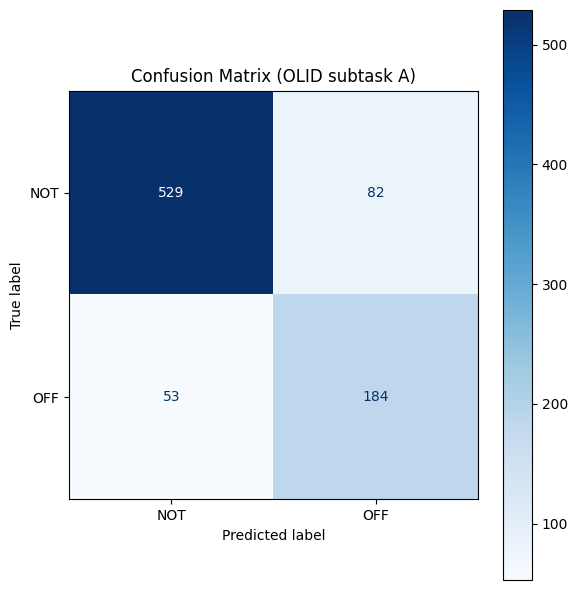

In [75]:
# --- Build or reuse Test DataLoader if df_test exists ---
test_loader = None
inference_only = False

if df_test is not None and len(df_test) > 0:
    has_labels = 'label' in df_test.columns
    # Create Dataset (labels=None if doing inference)
    test_dataset = TextClassificationDataset(
        texts=df_test['clean_text'].tolist(),
        labels=df_test['label'].tolist() if has_labels else None,
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    if has_labels:
        print(f"Built evaluation DataLoader for {len(test_dataset)} labeled test samples.")
    else:
        inference_only = True
        print(f"Built inference DataLoader for {len(test_dataset)} test samples (no labels).")
else:
    print("No test data found; skipping test loader.")

# --- Run final evaluation or inference ---
if test_loader is None:
    print("\nSkipping test set evaluation/inference (no test_loader).")

elif not inference_only:
    # ----- EVALUATION WITH LABELS -----
    print("\nEvaluating on Test Set...")
    # Reuse eval_epoch to get loss, accuracy, and F1
    test_loss, test_acc, test_f1, test_precision, test_recall, _, _ = eval_epoch(test_loader)

    # To compute precision and recall, we need all preds & labels
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            masks     = batch['attention_mask'].to(device)
            labels    = batch['labels'].to(device)

            logits = model(input_ids, attention_mask=masks).logits
            preds  = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Print scalar metrics
    print(f"Test Loss:      {test_loss:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Test F1-score:  {test_f1:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall:    {test_recall:.4f}")

    # Detailed classification report
    int_labels   = [v for _, v in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    target_names = [k for k, _ in sorted(LABEL_MAP.items(), key=lambda x: x[1])]

    report = classification_report(
        y_true=all_labels,
        y_pred=all_preds,
        labels=int_labels,
        target_names=target_names,
        digits=4,
        zero_division=0
    )
    print("\nClassification Report:")
    print(report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=int_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix ({DATASET_TYPE} subtask {SUBTASK.upper()})')
    fig.tight_layout()

    # Save figure
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    cm_path = os.path.join(OUTPUT_DIR, f'cm_{DATASET_TYPE}_{SUBTASK}.png')
    fig.savefig(cm_path)
    print(f"Saved confusion matrix to {cm_path}")

elif inference_only:
    # ----- INFERENCE-ONLY, NO TRUE LABELS -----
    print("\nRunning inference on unlabeled Test Set...")
    model.eval()
    all_preds = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            masks     = batch['attention_mask'].to(device)
            logits    = model(input_ids, attention_mask=masks).logits
            preds     = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())

    # Map back to label strings
    inv_label_map = {v: k for k, v in LABEL_MAP.items()}
    pred_strs = [inv_label_map[p] for p in all_preds]

    # Save predictions
    out_df = pd.DataFrame({
        'id':           df_test.get('id', range(len(all_preds))),
        'prediction':   all_preds,
        'prediction_str': pred_strs
    })
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    out_path = os.path.join(
        OUTPUT_DIR,
        f'{DATASET_TYPE}_subtask{SUBTASK.upper()}_predictions.csv'
    )
    out_df.to_csv(out_path, index=False)
    print(f"▶️ Inference done. Saved predictions to {out_path}")

    # Sample balanced view of predictions
    n_display   = 20
    pred_classes = out_df['prediction_str'].unique().tolist()
    per_class   = max(1, n_display // len(pred_classes))
    
    # Sample per class, ensuring at least one sample per class
    sampled = (
        out_df
        .groupby('prediction_str', group_keys=False)
        .apply(lambda grp: grp.sample(min(len(grp), per_class), random_state=SEED))
    )
    if len(sampled) > n_display:
        sampled = sampled.sample(n_display, random_state=SEED)
    sampled = sampled.sample(frac=1, random_state=SEED).reset_index(drop=True)

    print("\nSample predictions (balanced across predicted classes):")
    print(sampled)


## 11. Save Artifacts and Results

Save the trained model, tokenizer, training history plots, and final results.


Saving artifacts...
Best model and tokenizer saved to: model_output/best_model_subtask_a
Training history plot saved to model_output/best_training_history_RoBERTA_OLID_subtask_a.png
Results saved to model_output/results_OLID_subtask_a.json


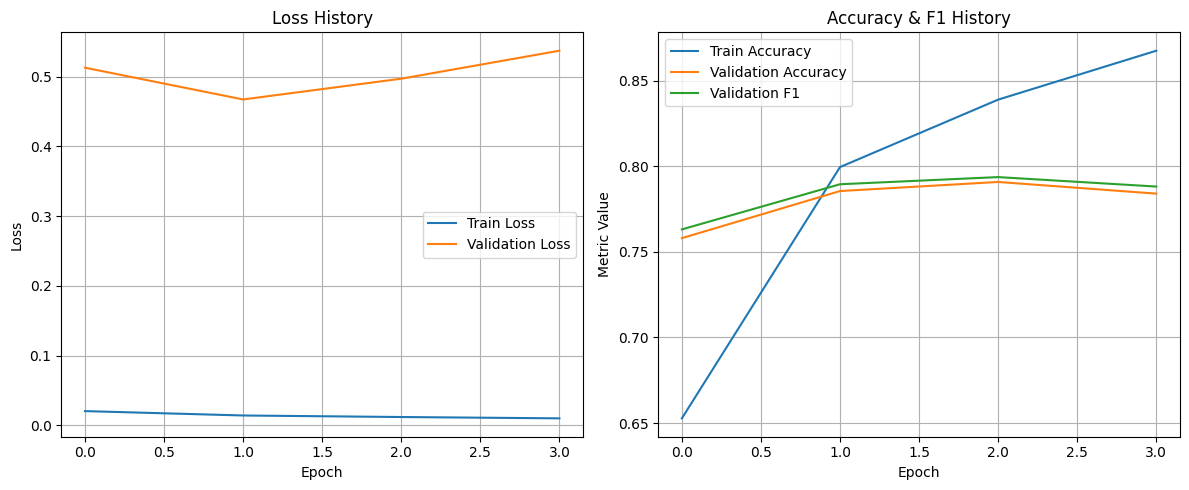

In [76]:
print("\nSaving artifacts...")

# --- Save Model and Tokenizer ---
# Construct a unique path using dataset name and subtask
model_save_path = os.path.join(OUTPUT_DIR, f"best_model_subtask_{SUBTASK}")
try:
    # save_pretrained writes both the model weights and the config
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Best model and tokenizer saved to: {model_save_path}")
except Exception as e:
    print(f"Error saving model or tokenizer: {e}")

# --- Plot Training History ---
# Create a two‐panel figure for loss and accuracy/F1 curves
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy & F1 subplot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'],   label='Validation Accuracy')
plt.plot(history['val_f1'],    label='Validation F1')
plt.title('Accuracy & F1 History')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
history_plot_path = os.path.join(
    OUTPUT_DIR,
    f"best_training_history_RoBERTA_{DATASET_TYPE}_subtask_{SUBTASK}.png"
)
try:
    plt.savefig(history_plot_path)
    print(f"Training history plot saved to {history_plot_path}")
    # plt.show()  # Uncomment this line if you want to display inline in a notebook
except Exception as e:
    print(f"Error saving history plot: {e}")

# --- Save Configuration and Results to JSON ---
# Convert confusion matrix to a serializable form (list of lists)
cm_data = cm.tolist() if hasattr(cm, 'tolist') else cm

results = {
    'config': config_dict,  # from earlier in your script
    'training_info': {
        'epochs_run': len(history['train_loss']),
        'total_training_time_seconds': total_time,
        'best_model_epoch': best_epoch if best_model_state is not None else None,
        'best_model_state': best_model_state is not None,
        'best_validation_loss': best_val_loss if best_model_state is not None else None,
        'best_epoch': best_epoch if best_model_state is not None else None
    },
    'history': history,
    'test_metrics': {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1_score_weighted': test_f1,
        'precision_weighted': test_precision,
        'recall_weighted': test_recall
    },
    'classification_report': report,
    'confusion_matrix': cm_data
}

# Write results to a JSON file named by dataset and subtask
results_filename = f"results_{DATASET_TYPE}_subtask_{SUBTASK.lower()}.json"
results_path     = os.path.join(OUTPUT_DIR, results_filename)

try:
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {results_path}")
except Exception as e:
    print(f"Error saving results JSON: {e}")


## 12. Comparing Classification Reports

,dataset,subtask,accuracy,f1_weighted
0,HASOC,1,0.807124,0.814851
1,HASOC,2,0.625000,0.594251
2,HASOC,3,0.326389,0.361326
3,OLID,a,0.840802,0.843456
4,OLID,b,0.756303,0.798953
5,OLID,c,0.672986,0.674960


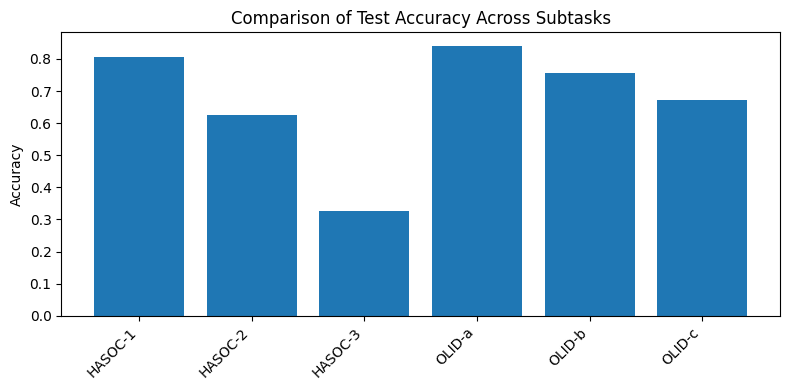

In [70]:

# List the datasets & subtasks you care about
configs = [
    ('HASOC',      '1'),
    ('HASOC',      '2'),
    ('HASOC',      '3'),
    ('OLID','a'),
    ('OLID','b'),
    ('OLID','c'),
]

results = []
for ds, st in configs:
    # load the JSON you saved in each run: results_{DS}_subtask{ST}.json
    fn = f"results_{ds}_subtask_{st}.json"
    path = os.path.join(OUTPUT_DIR, fn)
    try:
        with open(path) as f:
            r = json.load(f)
        acc = r['test_metrics']['accuracy']
        f1  = r['test_metrics']['f1_score_weighted']
        results.append({
            'dataset': ds,
            'subtask': st,
            'accuracy': acc,
            'f1_weighted': f1
        })
    except FileNotFoundError:
        print(f"⚠️  Could not find {path}, skipping.")

# Build a DataFrame and display
df = pd.DataFrame(results)
display(df)

plt.figure(figsize=(8,4))
plt.bar(
    [f"{r['dataset']}-{r['subtask']}" for r in results],
    [r['accuracy'] for r in results]
)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.title("Comparison of Test Accuracy Across Subtasks")
plt.tight_layout()
plt.show()


## 13. Explainability (Attention Visualization)

 Visualizing attention helps in understanding which parts of the input text the model focuses on when making predictions, thereby offering insights into its decision-making process. We'll use custom plotting functions with matplotlib and seaborn for flexibility and control.

### Helper Function to Extract Attentions and Tokens

This utility function handles the preprocessing of text, tokenization, running the model to get attention weights, and preparing tokens for visualization.

In [71]:
def get_roberta_attentions_and_tokens(
    model: AutoModelForSequenceClassification, 
    tokenizer: AutoTokenizer, 
    text: str, 
    device: torch.device, 
    max_len: int
) -> tuple | None:
    """
    Returns cleaned tokens (no Ġ), corresponding attention matrices, 
    and the preprocessed text.
    """

    # 1) Ensure attentions are enabled
    if not model.config.output_attentions:
        raise ValueError("Model must be loaded with output_attentions=True")

    # 2) Preprocess text
    processed_text = preprocess_text(text)

    # 3) Tokenize & move to device
    inputs = tokenizer(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    ).to(device)

    input_ids      = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # 4) Forward pass to get attentions
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    attentions = outputs.attentions  # tuple per layer

    # 5) Convert and clean tokens
    raw_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().tolist())
    # Strip the Ġ prefix from _every_ token
    clean_tokens = [tok.lstrip('Ġ') for tok in raw_tokens]

    # 6) Determine effective length (exclude padding)
    effective_len = int(attention_mask[0].sum().item())

    # 7) Slice tokens and attentions to effective length
    tokens_effective = clean_tokens[:effective_len]
    attentions_per_layer = [
        layer[0, :, :effective_len, :effective_len].cpu()
        for layer in attentions
    ]

    return tokens_effective, attentions_per_layer, processed_text

### Custom Plotting Functions

These functions will generate the actual visualizations (2D heatmaps for token-to-token attention and bar charts for [CLS] token attention).

In [72]:
# Cell 3: Custom Plotting Functions for Attention
def plot_attention_heatmap(
    attention_matrix: np.ndarray, 
    x_labels: list, 
    y_labels: list, 
    title: str = "Attention Heatmap",
    figsize_base: tuple = (0.7, 0.5), # Width, height per token
    min_figsize: tuple = (8, 6), # Minimum figure size
    cmap: str = "viridis",
    annot: bool = False # Set to True to show attention scores on the heatmap (for small matrices)
):
    """Plots a 2D attention matrix as a heatmap using Seaborn."""
    num_x_tokens = len(x_labels)
    num_y_tokens = len(y_labels)
    
    fig_width = max(min_figsize[0], num_x_tokens * figsize_base[0])
    fig_height = max(min_figsize[1], num_y_tokens * figsize_base[1])
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.heatmap(attention_matrix, xticklabels=x_labels, yticklabels=y_labels, cmap=cmap, annot=annot, fmt=".2f", ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Attending To (Key)", fontsize=12)
    ax.set_ylabel("Attended From (Query)", fontsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout(pad=0.5)
    return fig


def plot_cls_token_attention_barchart(
    cls_attention_scores: np.ndarray, 
    tokens: list, # Full list of tokens including [CLS]
    tokenizer: AutoTokenizer, # Pass tokenizer to identify CLS token
    title: str = "[CLS] Token Attention to Other Tokens",
    figsize_base_width_per_token: float = 0.6,
    min_fig_width: float = 8,
    fig_height: float = 4
):
    """Plots attention scores from [CLS] token to other tokens as a bar chart."""
    cls_token_str = tokenizer.cls_token
    
    # Exclude [CLS] token itself from the bar chart's x-axis
    plot_tokens = tokens[1:] if tokens and tokens[0] == cls_token_str else tokens
    plot_scores = cls_attention_scores[1:] if tokens and tokens[0] == cls_token_str else cls_attention_scores
    
    if not plot_tokens: 
        print(f"Warning: No tokens to plot for '{title}'. Sequence might be too short or only contain [CLS].")
        return None

    fig_width = max(min_fig_width, len(plot_tokens) * figsize_base_width_per_token)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    ax.bar(plot_tokens, plot_scores, color='skyblue')
    ax.set_xticks(np.arange(len(plot_tokens))) # Ensure all labels are shown
    ax.set_xticklabels(plot_tokens, rotation=75, ha="right", fontsize=10)
    ax.set_ylabel("Average Attention Score from [CLS]")
    ax.set_title(title, fontsize=14)
    plt.tight_layout(pad=0.5)
    return fig

### Main Visualization Workflow Function

This improved function orchestrates the process of getting attentions and calling the plotting functions. It allows selecting layers and heads.

In [73]:
# Cell 4: Main Visualization Workflow Function
def visualize_attention(
    model: AutoModelForSequenceClassification, 
    tokenizer: AutoTokenizer, 
    text: str, 
    device: torch.device, 
    max_len: int,
    layer_to_viz: int = -1,          # Default to last layer (-1 means last, -2 second last etc.)
    head_to_viz: str | int = 'average', # Options: 'average', 'all', or a specific head index (0 to num_heads-1)
    output_dir: str = "model_output", # Directory to save plots
    sample_id: str = "sample",       # Identifier for filenames (e.g., DataFrame index or sample number)
    show_plots: bool = True,         # Whether to display plots inline
    save_plots: bool = True          # Whether to save plots to output_dir
):
    """
    Generates and optionally saves/shows attention visualizations for a given text, layer, and head.
    Produces:
    1. Bar chart of [CLS] token's average attention (across heads) to other tokens for the specified layer.
    2. 2D heatmap(s) of token-to-token attention for the specified layer and head(s).
    """
    os.makedirs(output_dir, exist_ok=True) # Ensure output directory exists

    attention_data = get_roberta_attentions_and_tokens(model, tokenizer, text, device, max_len)
    if attention_data is None:
        print(f"Could not retrieve attention data for sample {sample_id}.")
        return

    tokens, attentions_per_layer, processed_text = attention_data
    
    if not tokens:
        print(f"No tokens returned for sample {sample_id}, cannot visualize.")
        return

    num_layers = len(attentions_per_layer)
    num_heads = attentions_per_layer[0].shape[0] # (num_heads, seq_len, seq_len)

    # Validate and adjust layer_to_viz
    actual_layer_idx = layer_to_viz
    if actual_layer_idx < 0:
        actual_layer_idx = num_layers + actual_layer_idx 
    
    if not (0 <= actual_layer_idx < num_layers):
        print(f"Error: layer_to_viz ({layer_to_viz}, resolved to {actual_layer_idx}) is out of range (0-{num_layers-1}). Defaulting to last layer.")
        actual_layer_idx = num_layers - 1
        
    selected_layer_attentions = attentions_per_layer[actual_layer_idx] # Shape: (num_heads, effective_seq_len, effective_seq_len)

    # --- Plot 1: [CLS] Token Average Attention Bar Chart ---
    # Average attention across all heads for the selected layer
    avg_attention_all_heads_selected_layer = torch.mean(selected_layer_attentions, dim=0).numpy() 
    
    # Find [CLS] token index, default to 0 if not found (should always be there with add_special_tokens=True)
    try:
        cls_idx = tokens.index(tokenizer.cls_token)
    except ValueError:
        print(f"Warning: {tokenizer.cls_token} token not found in tokens list. Assuming index 0 for [CLS] attention.")
        cls_idx = 0
            
    cls_to_others_attention = avg_attention_all_heads_selected_layer[cls_idx, :]
    
    # Optional: Normalize [CLS] attention scores (excluding [CLS] itself)
    # score_sum = np.sum(cls_to_others_attention[cls_idx+1:])
    # if score_sum > 0:
    #    cls_to_others_attention[cls_idx+1:] = cls_to_others_attention[cls_idx+1:] / score_sum

    bar_title = f"[CLS] Avg. Head Attn. (L{actual_layer_idx}) - Sample {sample_id}\nText: \"{text[:40]}...\""
    fig_bar = plot_cls_token_attention_barchart(
        cls_attention_scores=cls_to_others_attention,
        tokens=tokens,
        tokenizer=tokenizer,
        title=bar_title
    )
    if fig_bar:
        if save_plots:
            bar_chart_path = os.path.join(output_dir, f"attn_bar_{sample_id}_L{actual_layer_idx}.png")
            try:
                fig_bar.savefig(bar_chart_path, bbox_inches='tight')
                print(f"Bar chart saved: {bar_chart_path}")
            except Exception as e:
                print(f"Error saving bar chart for sample {sample_id}: {e}")
        if show_plots:
            plt.show()
        plt.close(fig_bar)

    # --- Plot 2: Full Token-to-Token Attention Heatmap(s) ---
    plot_head_indices = []
    if head_to_viz == 'average':
        plot_head_indices.append('average')
    elif head_to_viz == 'all':
        plot_head_indices.extend(range(num_heads))
    elif isinstance(head_to_viz, int) and 0 <= head_to_viz < num_heads:
        plot_head_indices.append(head_to_viz)
    else:
        print(f"Notice: Invalid head_to_viz value: {head_to_viz}. Defaulting to 'average' for heatmap.")
        plot_head_indices.append('average')

    for head_spec in plot_head_indices:
        if head_spec == 'average':
            attention_matrix_for_plot = torch.mean(selected_layer_attentions, dim=0).numpy()
            head_label = "AvgHead"
        else: # Specific head index
            attention_matrix_for_plot = selected_layer_attentions[head_spec, :, :].numpy()
            head_label = f"Head{head_spec}"

        heatmap_title = f"Token-to-Token Attn. (L{actual_layer_idx}, {head_label}) - Sample {sample_id}\nText: \"{text[:40]}...\""
        fig_heatmap = plot_attention_heatmap(
            attention_matrix=attention_matrix_for_plot,
            x_labels=tokens,
            y_labels=tokens,
            title=heatmap_title
        )
        if fig_heatmap:
            if save_plots:
                heatmap_filename = f"attn_heatmap_{sample_id}_L{actual_layer_idx}_{head_label}.png"
                heatmap_path = os.path.join(output_dir, heatmap_filename)
                try:
                    fig_heatmap.savefig(heatmap_path, bbox_inches='tight')
                    print(f"Heatmap saved: {heatmap_path}")
                except Exception as e:
                    print(f"Error saving heatmap for L{actual_layer_idx}, {head_label} (Sample {sample_id}): {e}")
            if show_plots:
                plt.show()
            plt.close(fig_heatmap)
            
    print(f"Finished visualization for sample {sample_id}.")

### Run Visualization Workflow
This cell reloads the best-performing model model with `output_attentions=True` and then iterates through a few samples from the test set to generate and display/save the visualizations.


Looking for best model in: model_output/best_model_RoBERTA_OLID_subtask_a.pt
Reloading model from model_output/best_model_RoBERTA_OLID_subtask_a.pt for attention visualization...
Model reloaded successfully for visualization.
Visualizing 5 samples for OLID subtask a...

Sample 1 (idx 664)
Text: bbnaija when we told u she is a child of grace we meant it we are busy no time to famz anybody teamceec url...
True: NOT (0)   Pred: NOT (0)
Bar chart saved: model_output/OLID/subtask_a/attention_viz/attn_bar_OLID_suba_idx664_L11.png


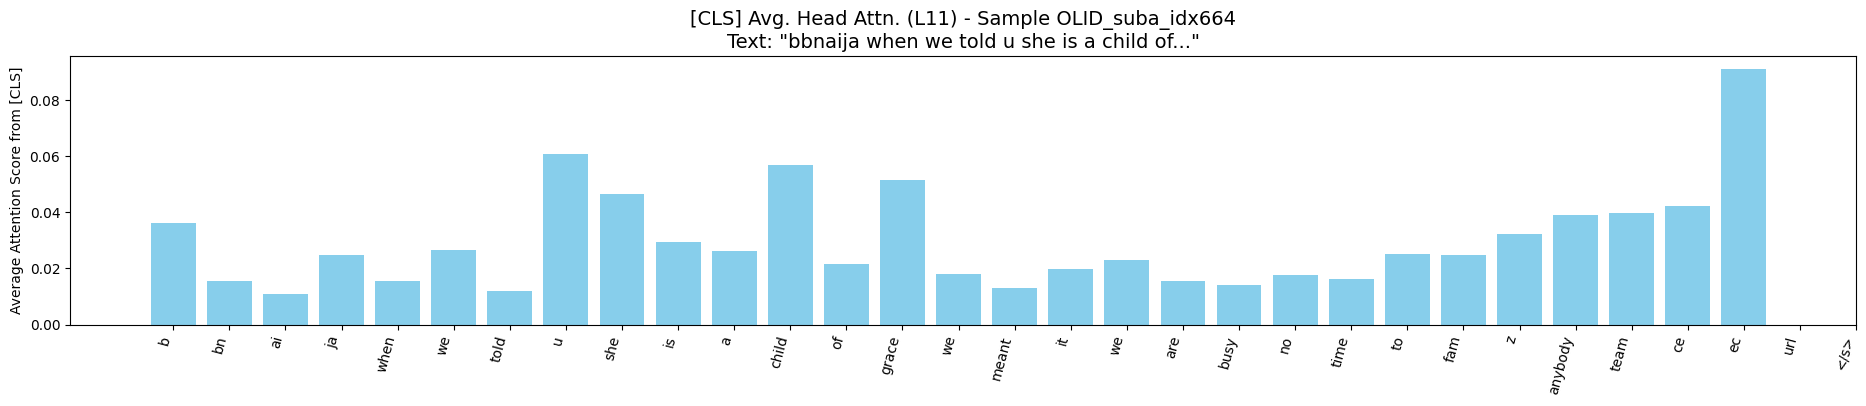

Heatmap saved: model_output/OLID/subtask_a/attention_viz/attn_heatmap_OLID_suba_idx664_L11_AvgHead.png


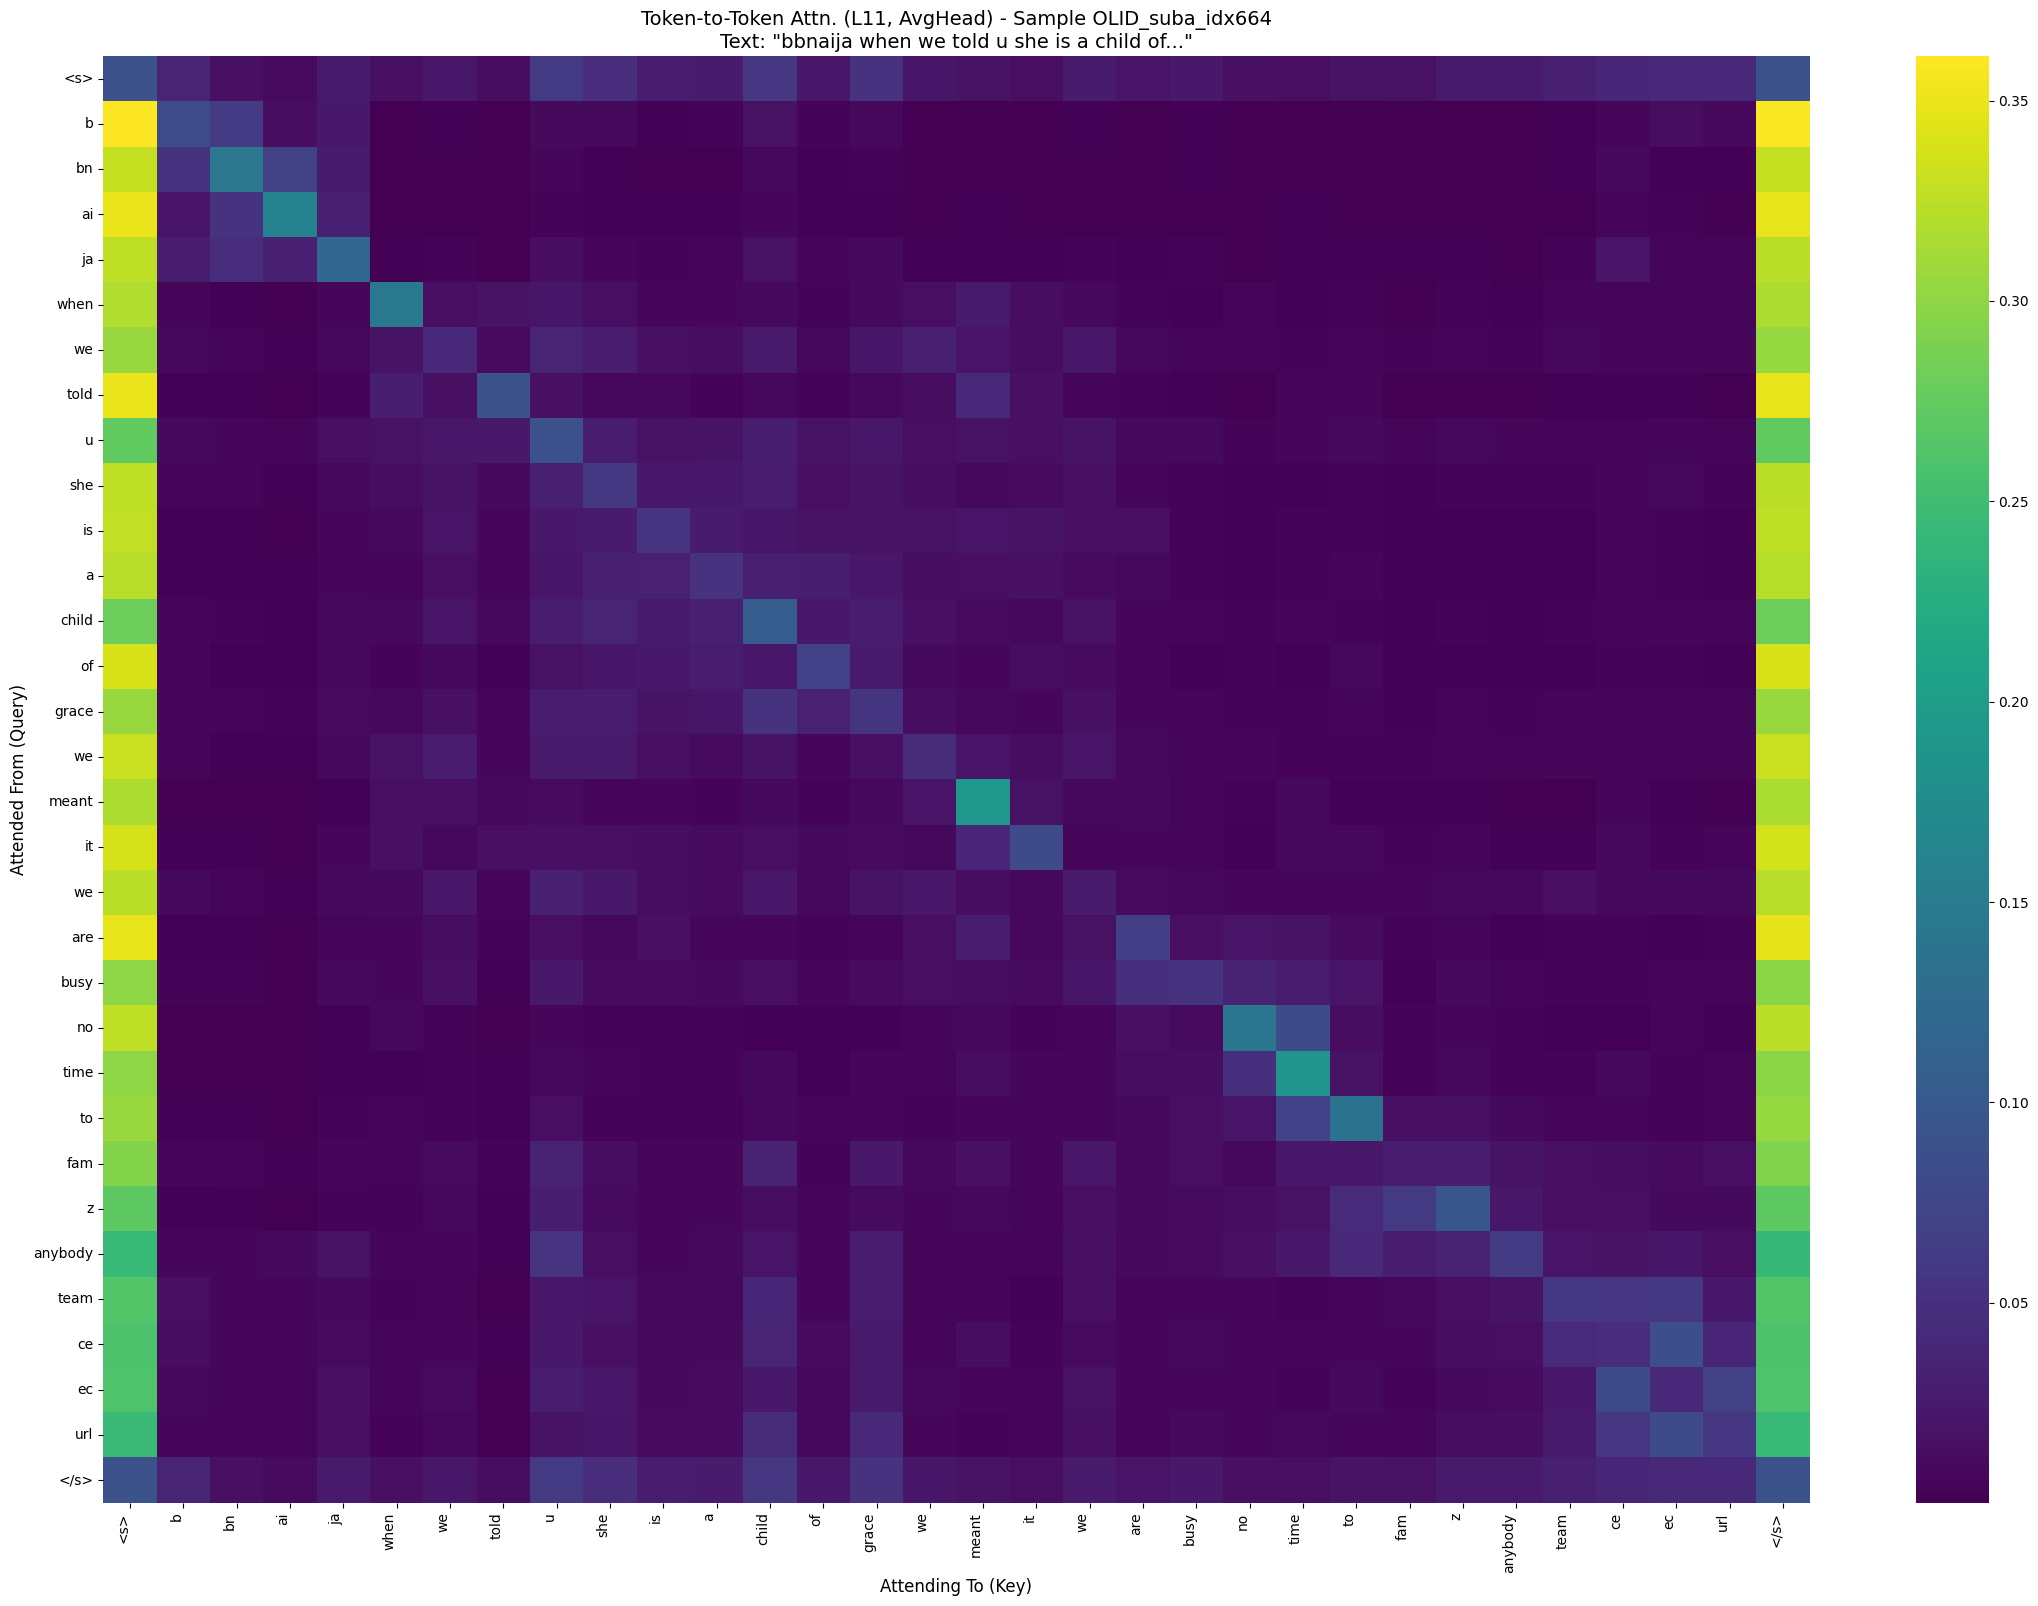

Finished visualization for sample OLID_suba_idx664.

Sample 2 (idx 363)
Text: liberals / democrats this is what you stand for. if not, then walkaway url...
True: OFF (1)   Pred: NOT (0)
Bar chart saved: model_output/OLID/subtask_a/attention_viz/attn_bar_OLID_suba_idx363_L11.png


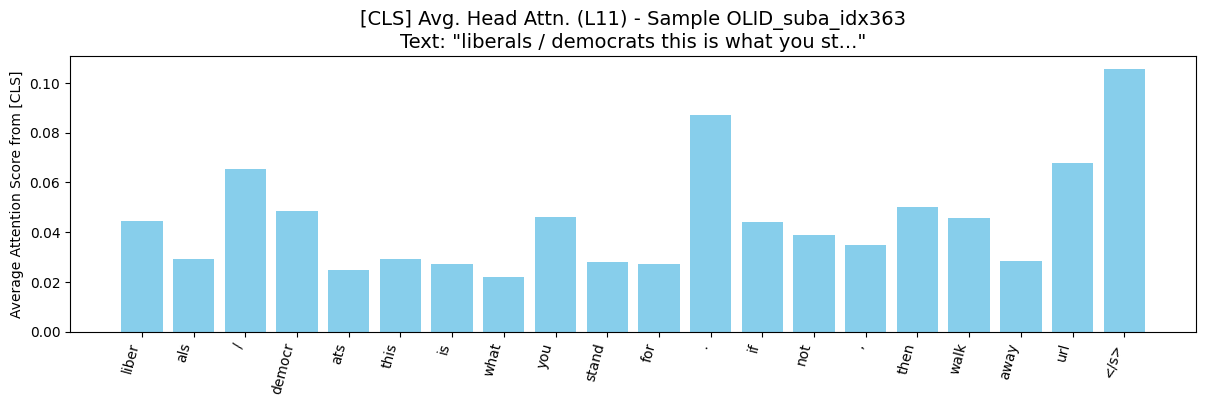

Heatmap saved: model_output/OLID/subtask_a/attention_viz/attn_heatmap_OLID_suba_idx363_L11_AvgHead.png


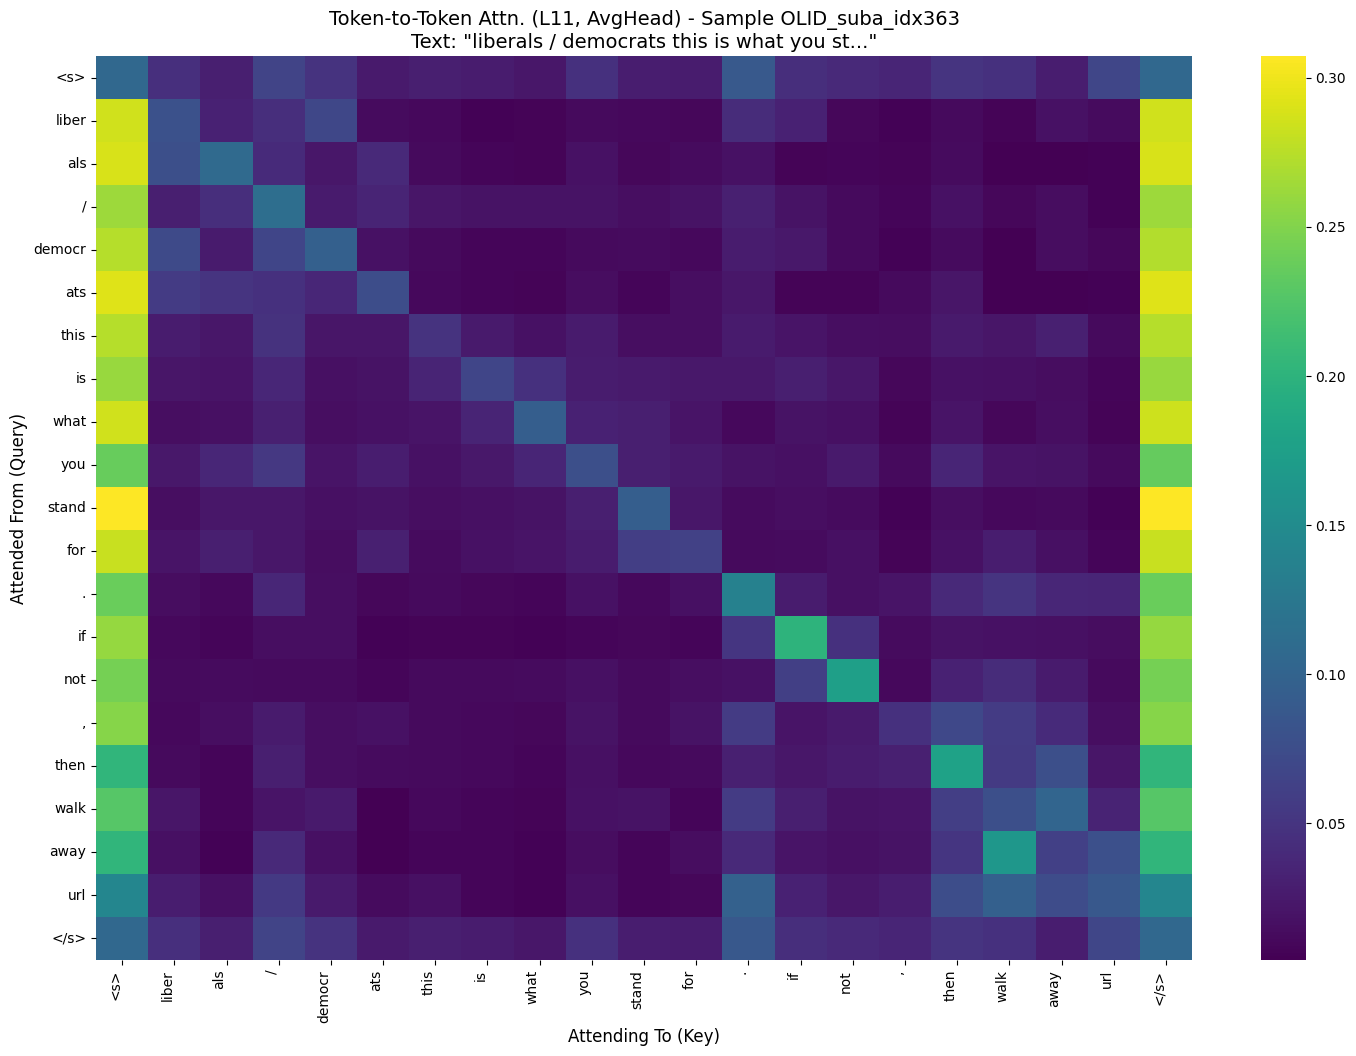

Finished visualization for sample OLID_suba_idx363.

Sample 3 (idx 110)
Text: jameycomey has been so silent these last few weeks, because he knows he is going to be indicted. 13 35 fbi doj strzok page textmessages qanon patriotsfight ty.@user maga url...
True: NOT (0)   Pred: NOT (0)
Bar chart saved: model_output/OLID/subtask_a/attention_viz/attn_bar_OLID_suba_idx110_L11.png


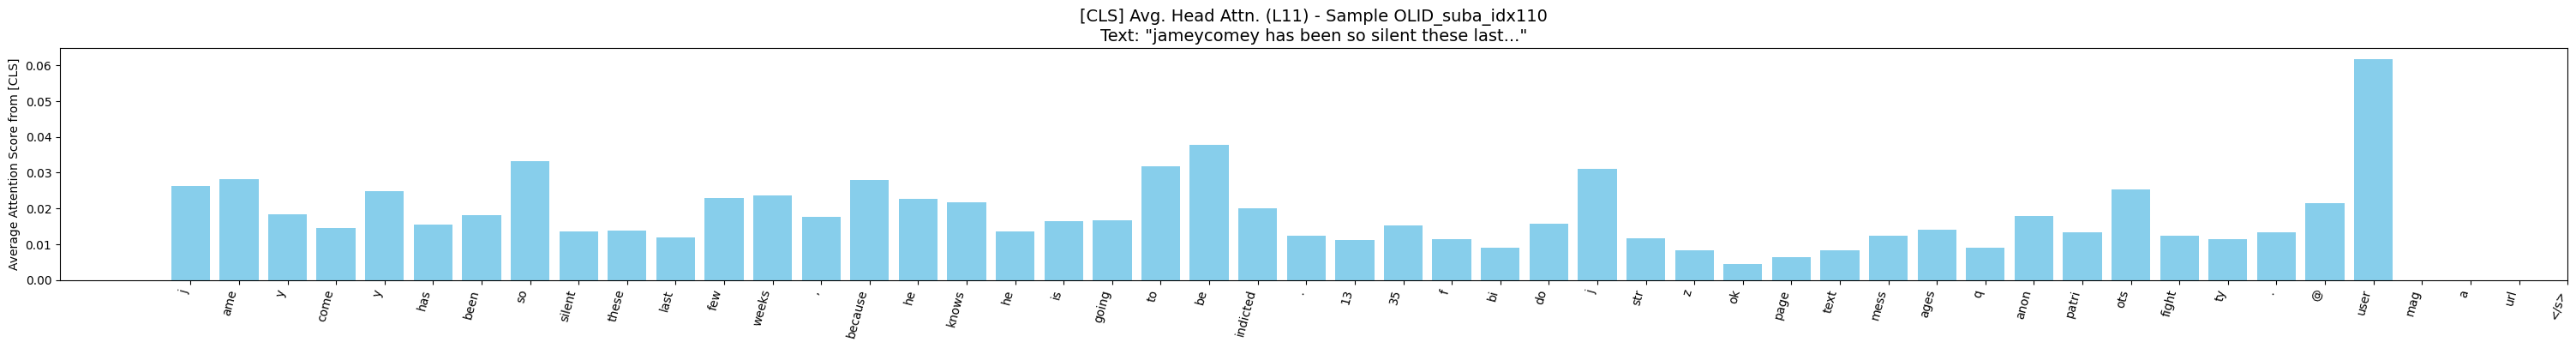

Heatmap saved: model_output/OLID/subtask_a/attention_viz/attn_heatmap_OLID_suba_idx110_L11_AvgHead.png


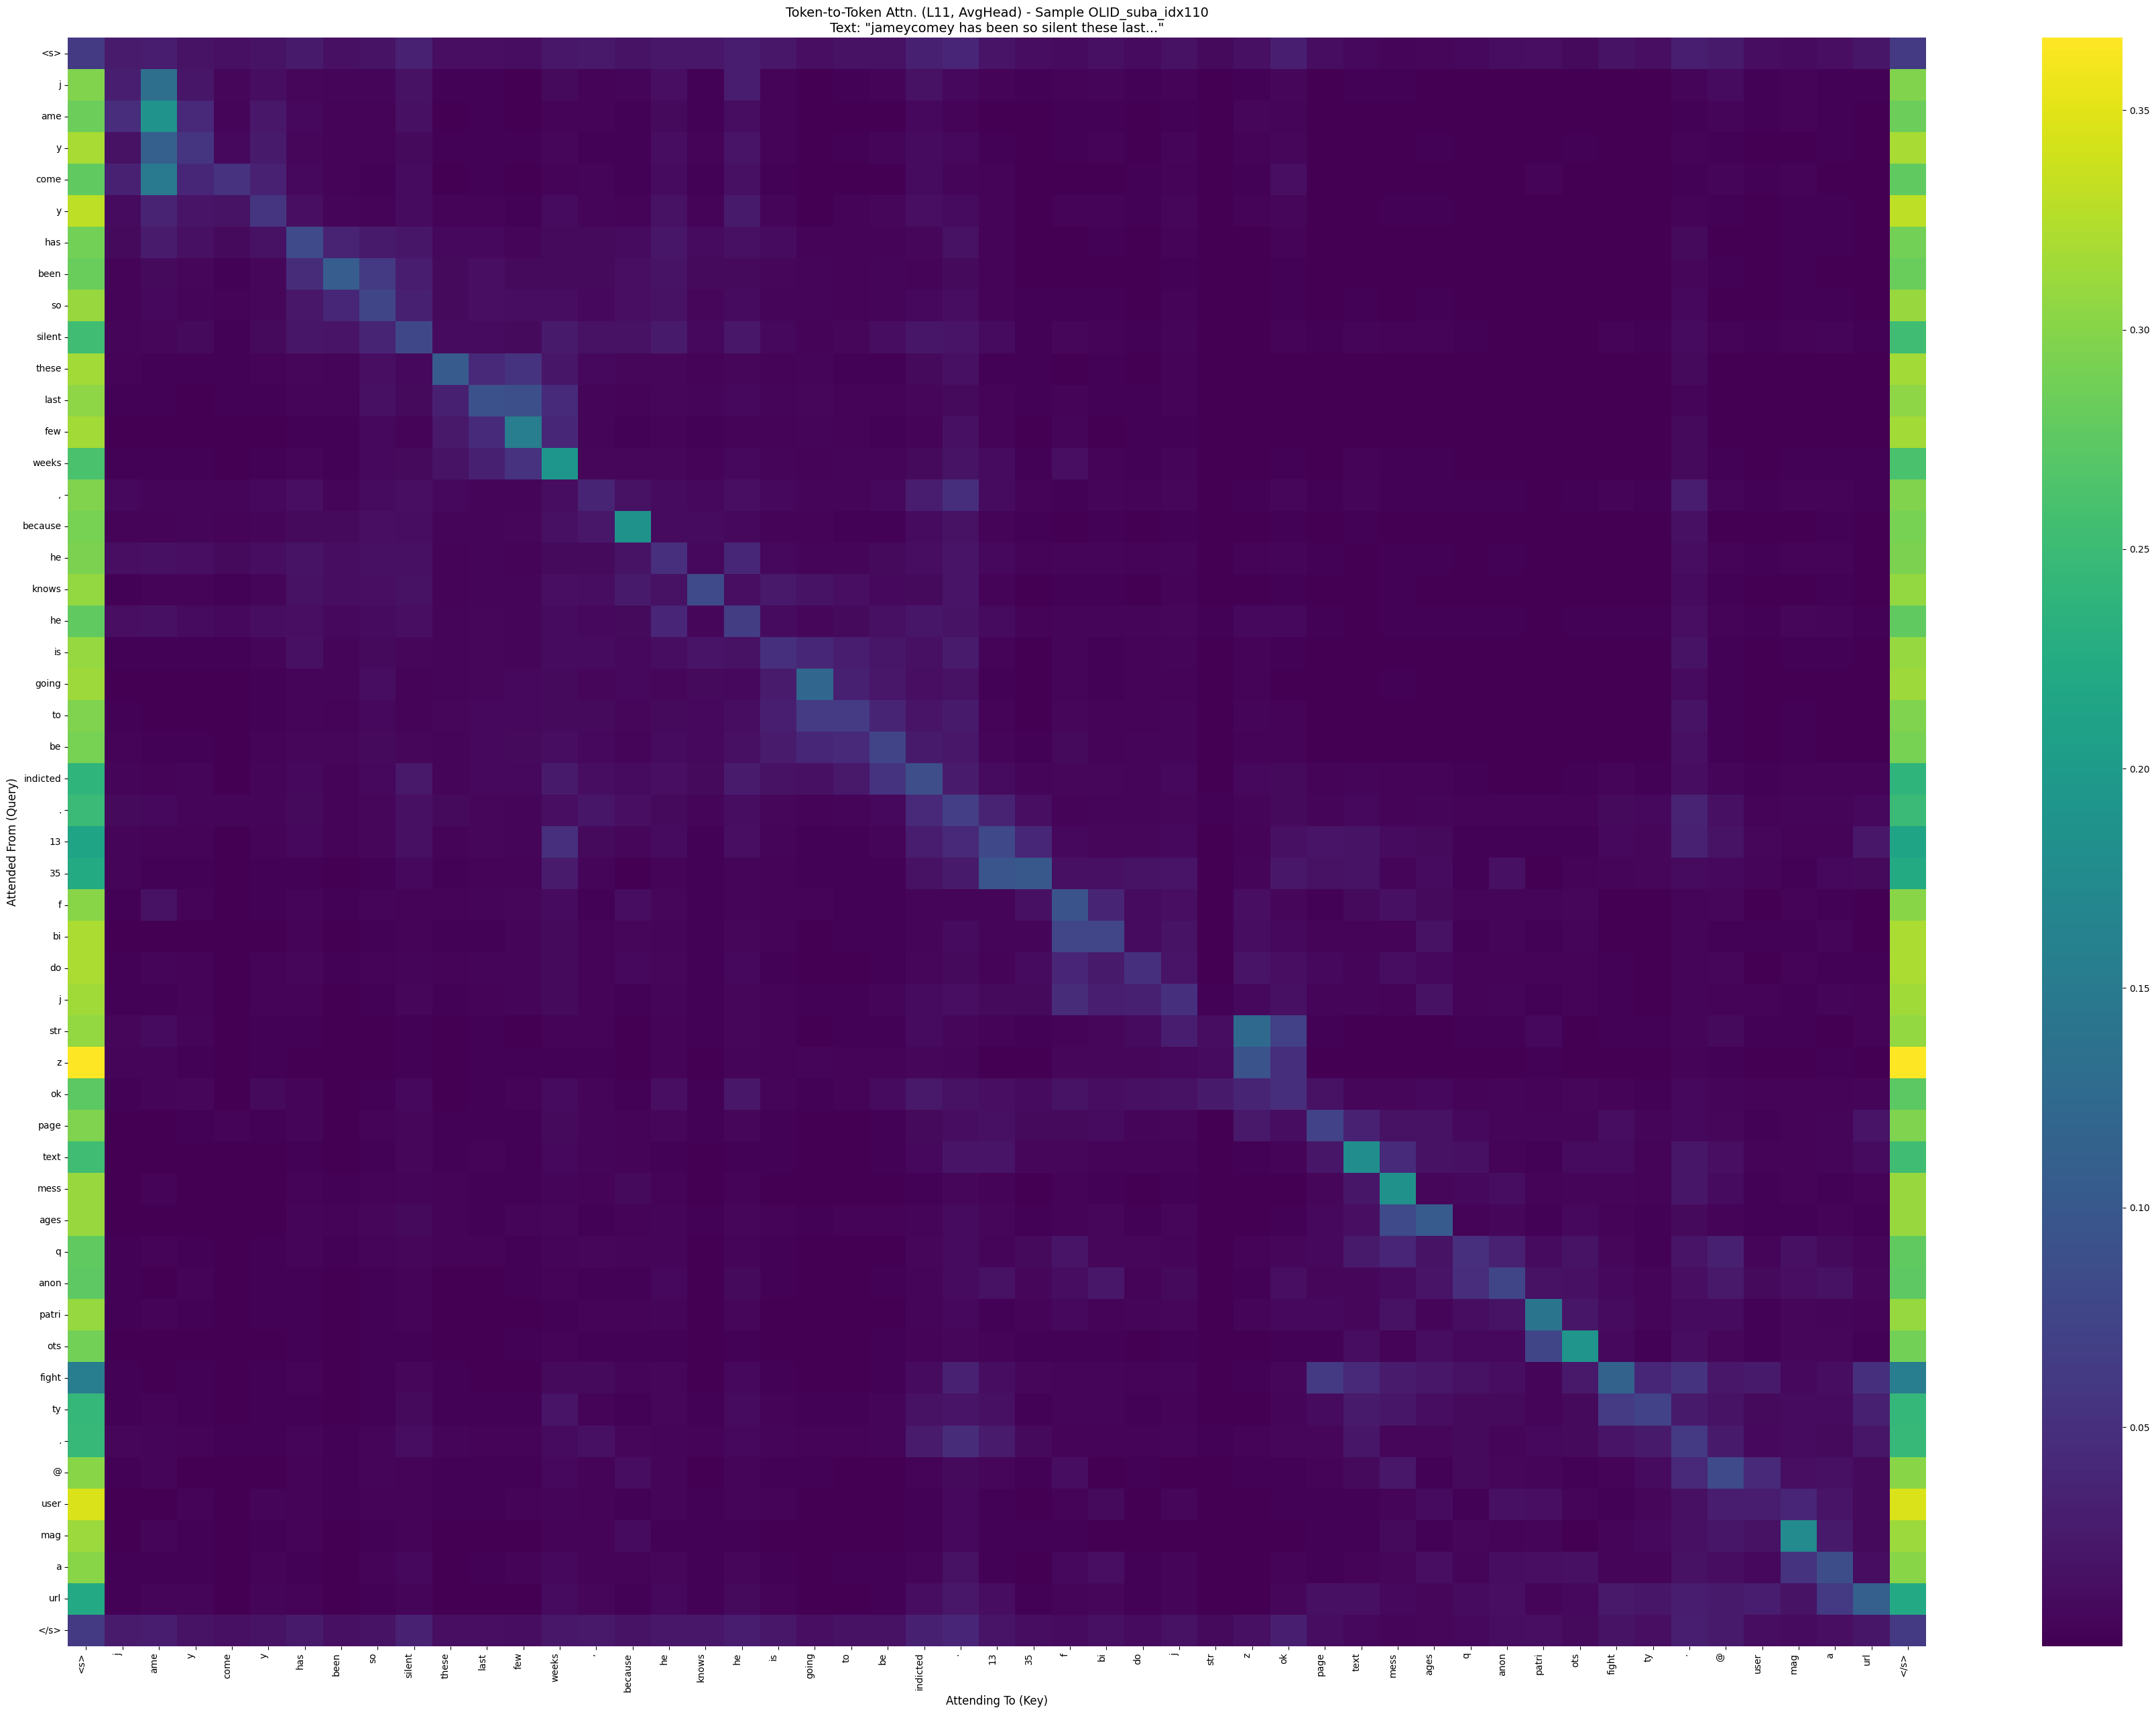

Finished visualization for sample OLID_suba_idx110.

Sample 4 (idx 678)
Text: sundayshoutouts to @user because.. because she is amazing and has my boundless support and endless appreciation for her support in return, it is just a loop of love and respect… url...
True: NOT (0)   Pred: NOT (0)
Bar chart saved: model_output/OLID/subtask_a/attention_viz/attn_bar_OLID_suba_idx678_L11.png


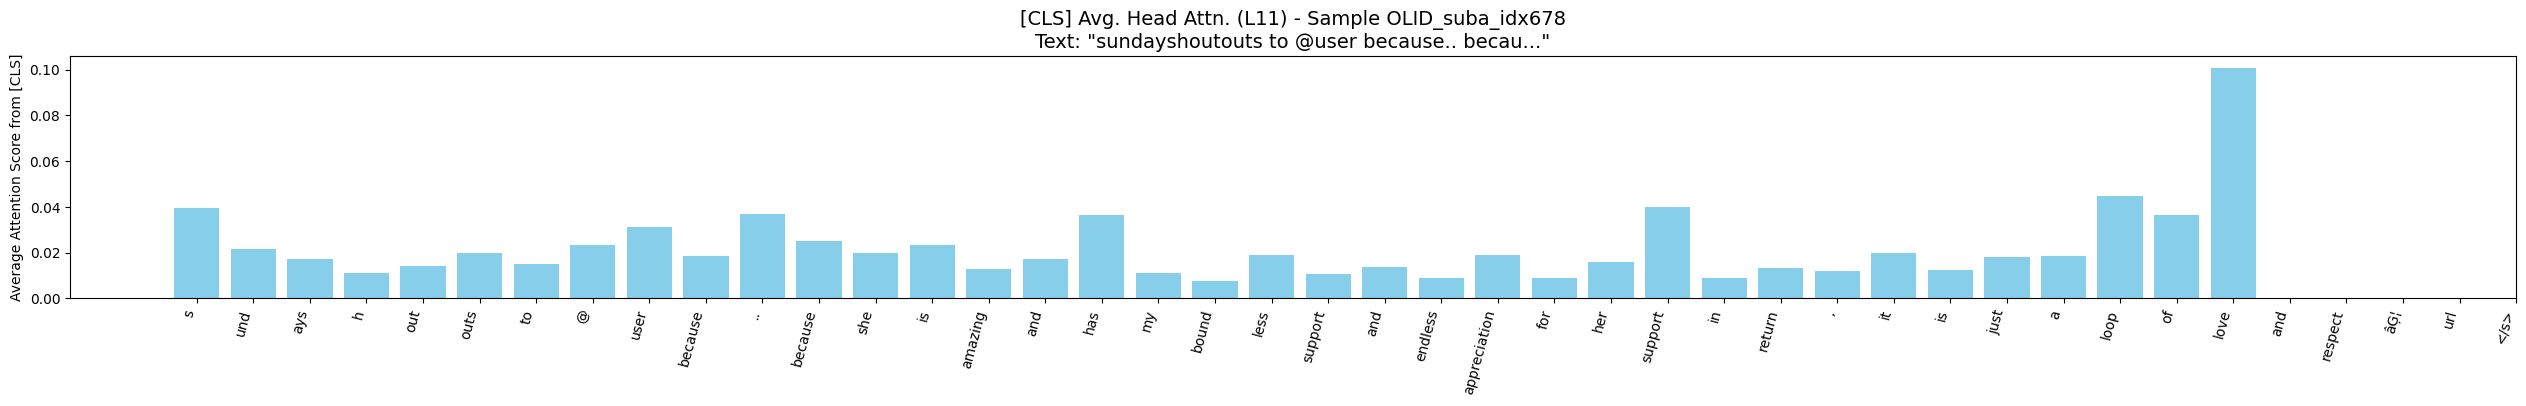

Heatmap saved: model_output/OLID/subtask_a/attention_viz/attn_heatmap_OLID_suba_idx678_L11_AvgHead.png


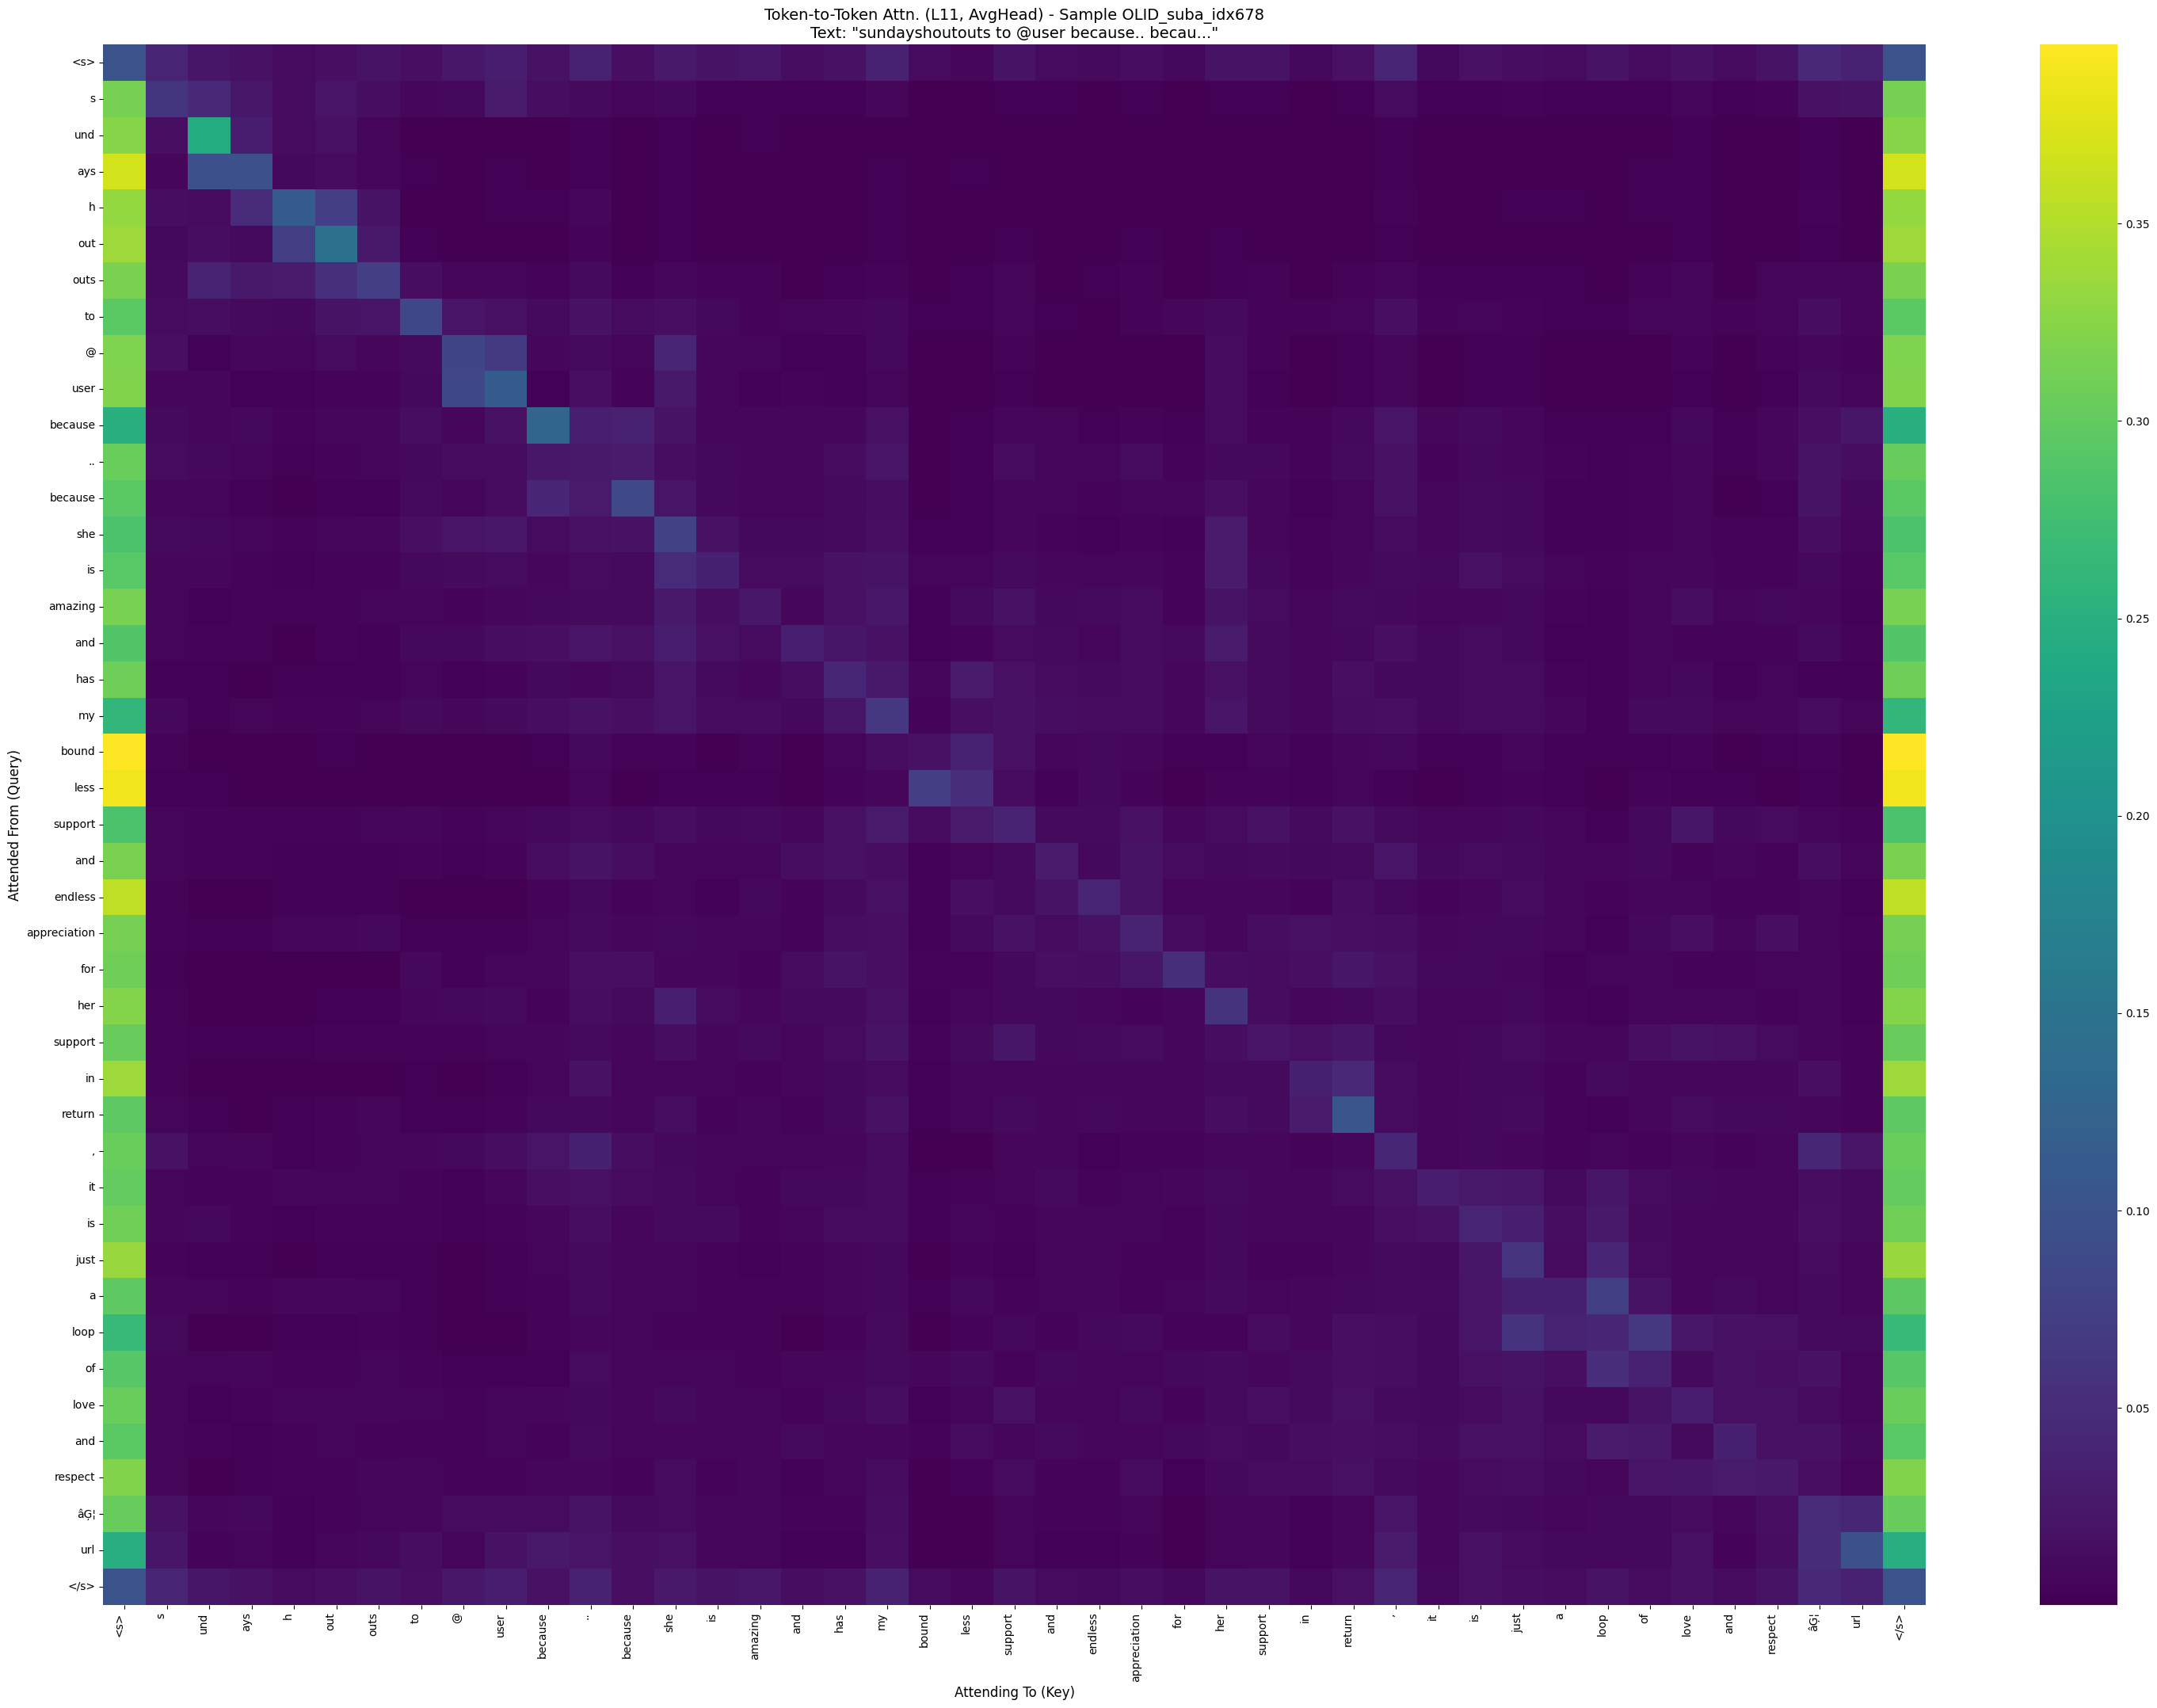

Finished visualization for sample OLID_suba_idx678.

Sample 5 (idx 39)
Text: @user how is she hiding her ugly personality. she is the worst....
True: OFF (1)   Pred: OFF (1)
Bar chart saved: model_output/OLID/subtask_a/attention_viz/attn_bar_OLID_suba_idx39_L11.png


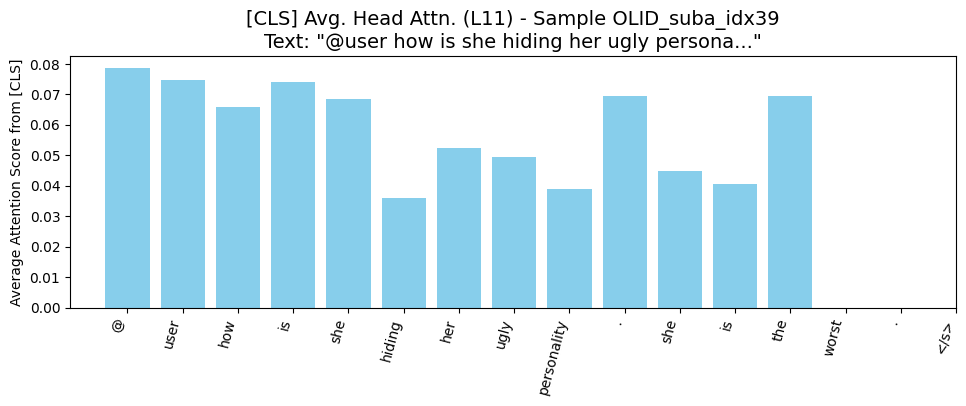

Heatmap saved: model_output/OLID/subtask_a/attention_viz/attn_heatmap_OLID_suba_idx39_L11_AvgHead.png


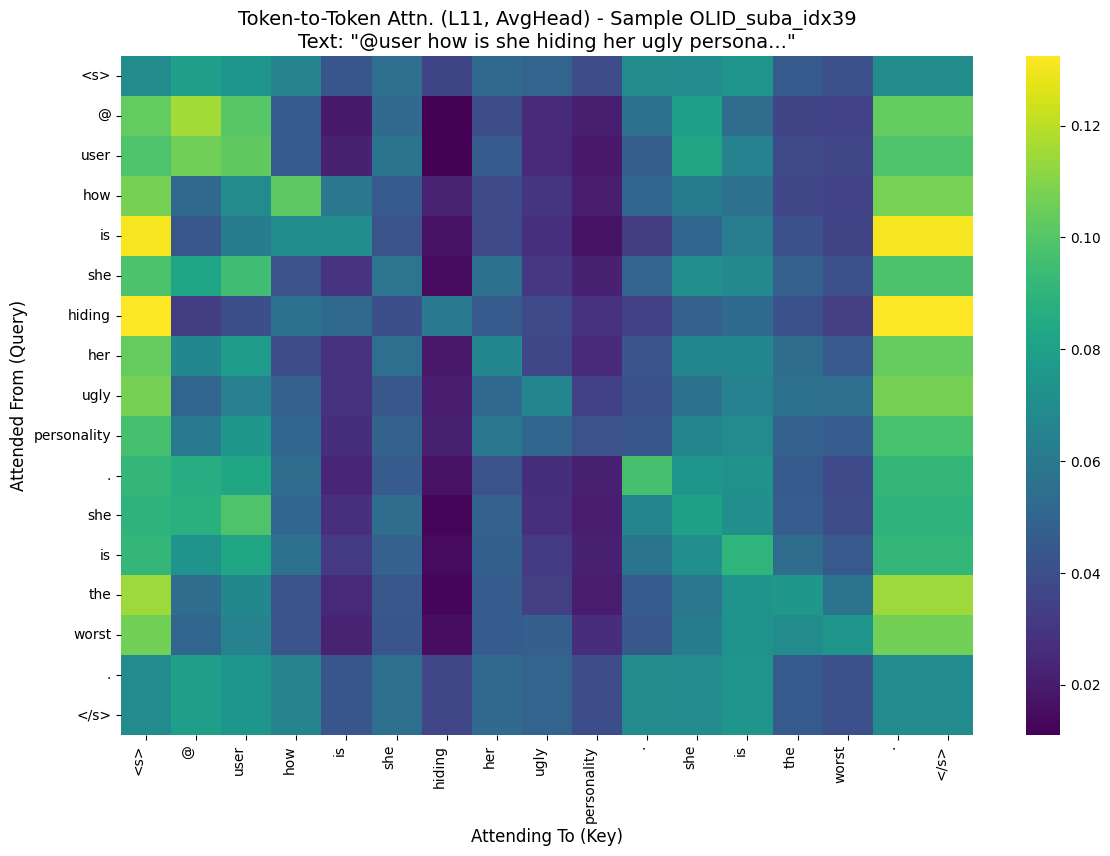

Finished visualization for sample OLID_suba_idx39.


In [74]:
# Reload Model and Run Visualization Workflow

# --- Construct per‐task model path ---
model_dir = os.path.join(OUTPUT_DIR, f"best_model_RoBERTA_{DATASET_TYPE}_subtask_{SUBTASK}.pt")
print(f"\nLooking for best model in: {model_dir}")

model_for_viz = None
if os.path.exists(model_dir):
    print(f"Reloading model from {model_dir} for attention visualization...")
    try:
        model_for_viz = AutoModelForSequenceClassification.from_pretrained(
            model_dir,
            output_attentions=True  # CRITICAL
        ).to(device)
        model_for_viz.eval()
        print("Model reloaded successfully for visualization.")
    except Exception as e:
        print(f"Error reloading model for visualization: {e}")
else:
    print(f"Error: Saved model not found at {model_dir}. Cannot perform attention visualization.")

# --- Visualize a few samples if ready ---
if model_for_viz is not None and 'df_test' in globals() and df_test is not None and not df_test.empty:
    # Prepare human‐readable label names
    try:
        target_names = [k for k,v in sorted(LABEL_MAP.items(), key=lambda item: item[1])]
    except NameError:
        print("Warning: LABEL_MAP not found; predictions will be numeric.")
        target_names = None

    n_viz = min(5, len(df_test))
    print(f"Visualizing {n_viz} samples for {DATASET_TYPE} subtask {SUBTASK}...")

    # reproducible sampling
    sample_idxs = df_test.sample(n=n_viz, random_state=SEED).index

    # ensure output dir for attention plots
    viz_dir = os.path.join(OUTPUT_DIR, DATASET_TYPE, f"subtask_{SUBTASK}", "attention_viz")
    os.makedirs(viz_dir, exist_ok=True)

    for i, idx in enumerate(sample_idxs):
        text = df_test.loc[idx, 'clean_text']
        # true label
        true_str = "N/A"
        if 'label' in df_test.columns and target_names:
            lab = df_test.loc[idx, 'label']
            true_str = f"{target_names[lab]} ({lab})"
        # predict
        enc = tokenizer.encode_plus(
            text, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='pt'
        ).to(device)
        with torch.no_grad():
            out = model_for_viz(**enc)
        pred_int = out.logits.argmax(dim=1).item()
        pred_str = f"{target_names[pred_int]} ({pred_int})" if target_names else str(pred_int)

        print(f"\nSample {i+1} (idx {idx})")
        print(f"Text: {text[:200]}...")
        print(f"True: {true_str}   Pred: {pred_str}")

        # run visualization
        visualize_attention(
            model=model_for_viz,
            tokenizer=tokenizer,
            text=text,
            device=device,
            max_len=MAX_LEN,
            layer_to_viz=-1,
            head_to_viz='average',
            output_dir=viz_dir,
            sample_id=f"{DATASET_TYPE}_sub{SUBTASK}_idx{idx}",
            show_plots=True,
            save_plots=True
        )
else:
    print("Skipping attention visualization: no model or test data available.")